# Visualization of autoencoders predictions

In [1]:
import torch
import numpy as np
import os
import tqdm
import time

from audIBle.data.datasets import UrbanSound8k
from audIBle.nn.autoencoders import SpecAE

import matplotlib.pyplot as plt
import json

In [2]:
from audIBle.config.autoenc_cfg import conf, common_parameters
from audIBle.config.utils import merge_configs

conf_id="002"
exp_conf = conf[conf_id]
config = merge_configs(common_parameters, exp_conf)

def normalize_wav(wav):
        energy = torch.sum(wav ** 2, dim=-1, keepdim=True)
        energy = torch.clamp(energy, min=1e-6)  # Avoid division by zero
        wav = wav / torch.sqrt(energy)
        return wav

In [3]:
dataset_root = config["data"]["root"]
dataset = UrbanSound8k(csv_path=os.path.join(dataset_root, "metadata/UrbanSound8K.csv"),
                        audio_dir=os.path.join(dataset_root, "audio"),
                        sample_rate=config["sample_rate"],
                        folds_to_use=config["data"]["folds_train"],
                        duration=4.0,)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [4]:
model = SpecAE(**config["model"])
import pprint
pprint.pprint(config["model"])

Input frequency dimension: 513
Hidden dimensions: [16, 32, 64, 128]
Encoder dimensions: [513, 257, 129, 65, 33]
Target output frequency dimension: 513
{'activation_slope': 0.2,
 'attention_dim': 64,
 'center': True,
 'hid_dims': [16, 32, 64, 128],
 'hop_length': 256,
 'input_channels': 1,
 'n_fft': 1024,
 'normalize_audio': True,
 'pad': 0,
 'scale': 'db',
 'use_attention': False,
 'win_length': 1024}


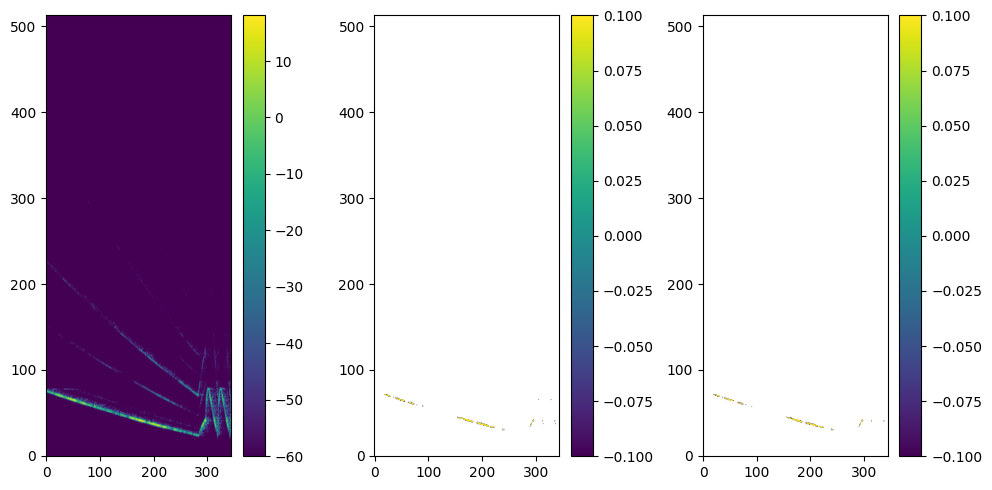

In [5]:
wav, label = dataset[500]

wav = normalize_wav(wav)

spec = model.spec(wav.unsqueeze(0))
spec = spec.squeeze()

fig, ax = plt.subplots(nrows=1, ncols=3, layout='tight', figsize=(10,5))

vmin = spec.min().item()
vmax = spec.max().item()
ax[0].imshow(spec, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(ax[0].images[0], ax=ax[0], orientation='vertical')

spec1 = torch.log(1+spec)
vmin = spec1.min().item()
vmax = spec1.max().item()
ax[1].imshow(spec1, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical')

spec2 = 10*torch.log10(torch.exp(spec1)-1+1e-6)
spec2_norm = spec2 / spec2.max()
vmin = spec2.min()
vmax = spec2.max()
ax[2].imshow(spec2, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
cbar = fig.colorbar(ax[2].images[0], ax=ax[2], orientation='vertical')

plt.show()


In [6]:
import os
exp_name="001_20250512-141210_250245_spec_autoencoder_urbasound8k_42"
exp_name="002_20250512-141149_250285_spec_autoencoder_urbasound8k_42"
model_name = "best_model.pth"
ckpt = torch.load(os.path.join(config["exp_dir"],exp_name,model_name), map_location="cpu")
model.load_state_dict(ckpt)
model.eval()

/tmp/ipykernel_4142145/3975751052.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(config["exp_dir"],exp_name,model_name), map_location="cp

SpecAE(
  (enc_dec): AttentiveAE(
    (encoder): Sequential(
      (block_0): ConvBlock(
        (conv): Conv2d(1, 16, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1))
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (block_1): ConvBlock(
        (conv): Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (block_2): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (block_3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1))
        (bn): Ba

In [9]:
def plot_spec_in_out(spec, spec_hat, epoch, scale):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    if scale == "log_biais":
        spec_lin = torch.exp(spec)-1
        spec_hat_lin = torch.exp(spec_hat)-1
        spec_lin = spec_lin / spec_lin.max()
        spec_hat_lin = spec_hat_lin / spec_hat_lin.max()
        spec_db = 10*torch.log10(spec_lin+1e-6)
        spec_hat_db = 10*torch.log10(spec_hat_lin+1e-6)
    elif scale == "log":
        spec_lin = torch.exp(spec)
        spec_hat_lin = torch.exp(spec_hat)
        spec_lin = spec_lin / spec_lin.max()
        spec_hat_lin = spec_hat_lin / spec_hat_lin.max()
        spec_db = 10*torch.log10(spec_lin+1e-6)
        spec_hat_db = 10*torch.log10(spec_hat_lin+1e-6)
    elif scale == "lin":
        spec_db = 10*torch.log10(spec+1e-6)
        spec_hat_db = 10*torch.log10(spec_hat+1e-6)
    else:
        spec_db = spec
        spec_hat_db = spec_hat

    vmin = spec_db.min()
    vmax = spec_db.max()
    dyn = vmax - vmin
    # vmax = vmax - 0.1*dyn
    ax[0].imshow(spec_db.cpu().numpy()[0], aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
    ax[0].set_title('Input Spectrogram')
    cbar = fig.colorbar(ax[0].images[0], ax=ax[0], orientation='vertical')
    cbar.set_label('Amplitude')
    ax[1].imshow(spec_hat_db.cpu().numpy()[0], aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
    ax[1].set_title('Reconstructed Spectrogram')
    cbar = fig.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical')
    cbar.set_label('Amplitude')

    return fig

  0%|          | 0/7079 [00:00<?, ?it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


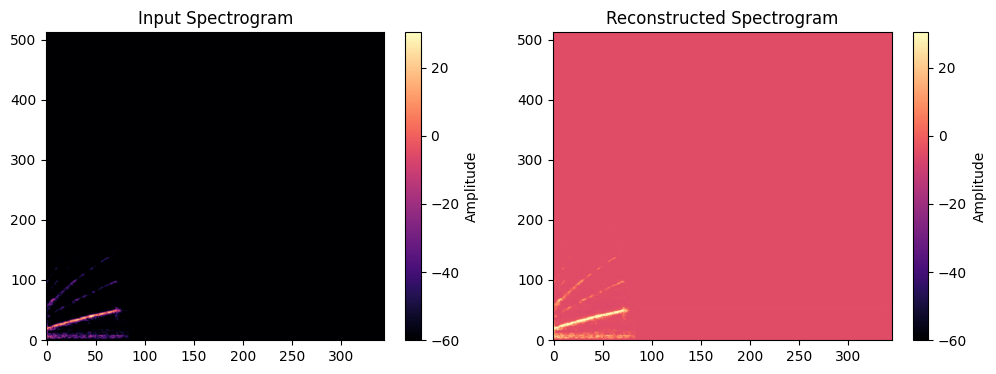

  0%|          | 1/7079 [00:00<1:09:04,  1.71it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


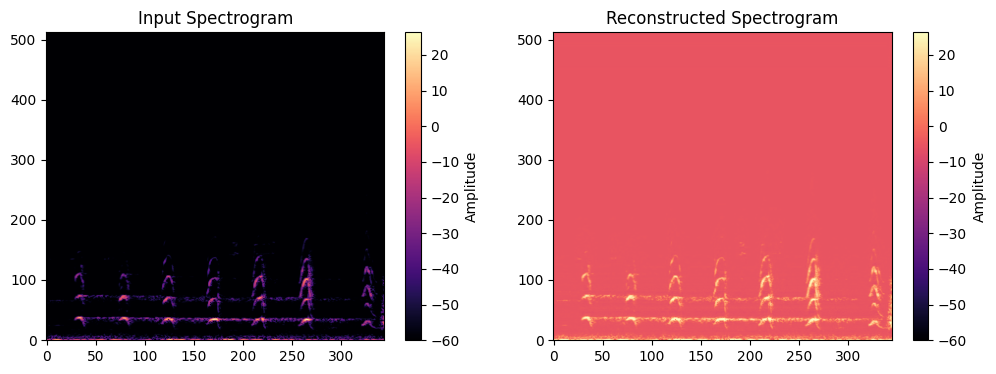

  0%|          | 2/7079 [00:01<1:10:40,  1.67it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


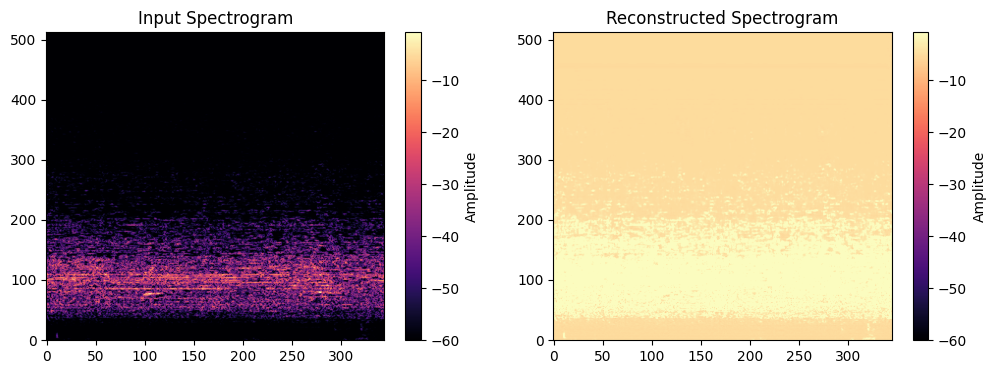

  0%|          | 3/7079 [00:02<1:22:14,  1.43it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


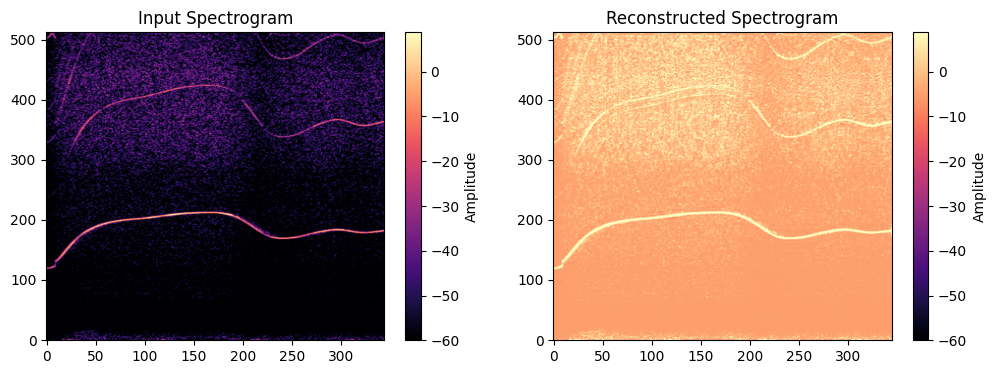

  0%|          | 4/7079 [00:02<1:15:54,  1.55it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


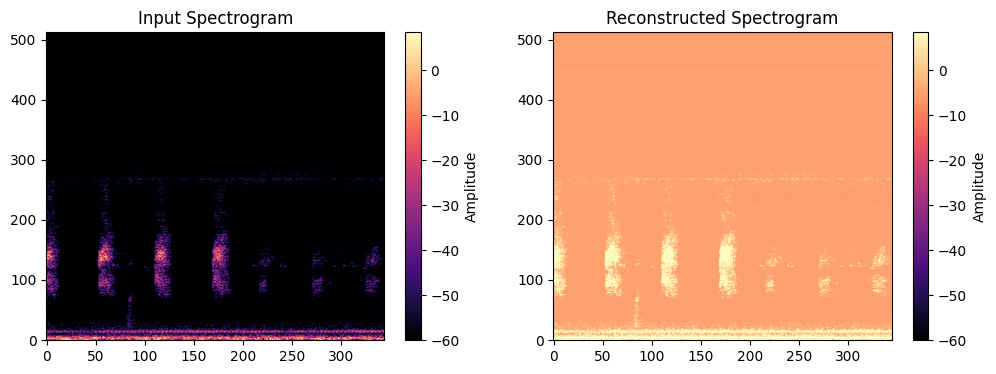

  0%|          | 5/7079 [00:03<1:08:50,  1.71it/s]

torch.Size([1, 1, 88200])
torch.Size([1, 1, 513, 345]) torch.Size([1, 1, 513, 345])


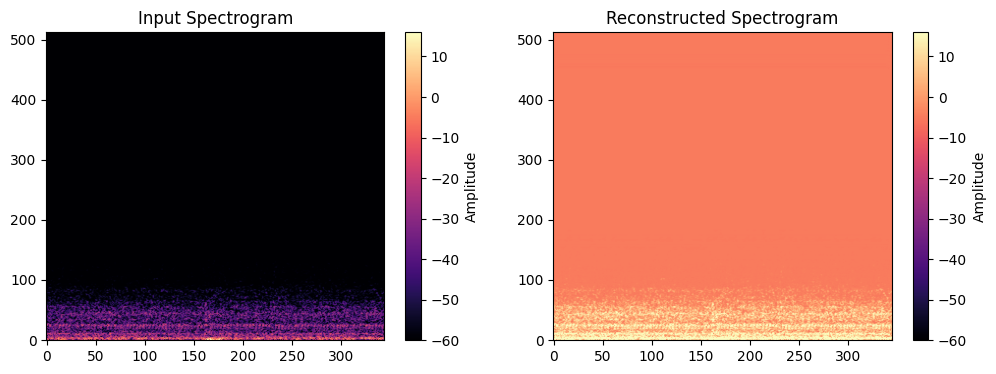

  0%|          | 5/7079 [00:03<1:22:43,  1.43it/s]


In [10]:
for i, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
    print(inputs.shape)
    x_hat, x, z, z_enh = model(inputs)
    print(x_hat.shape, x.shape)
    fig = plot_spec_in_out(x.detach().squeeze(1), x_hat.detach().squeeze(1), 0, scale=config["model"]["scale"])
    plt.show()

    if i == 5:
        break